<h1> Introduction/Business Problem

Without a doubt, gun violence in the US has become a huge problem in the past couple decades, effecting hundreds of thousands nationwide.  This project is seeking to explore the areas affected within the last year (2019) and determining which areas tend to be more at risk.

I am going to use the FourSquare API to search the top venues around each area the cluster them into groups to see how many end up in each cluster.  Then I'll additionally overlay that data with per capita income rates of each state/county in the country.

<h1> Data

1. The Gun Violence Archive contains public datasets containing the metadata of each mass shooting for every year, including location, time, and number of casualities.  
    1. https://www.gunviolencearchive.org/reports/mass-shooting
    
    
2. Wikipedia has a list of the per capita incomes by state and county for all states (mostly seperate for counties), and I will aggregate this data to make a choropleth map underlaying the clusters of shootings in recent months.
    1. by state: https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income#States_and_territories_ranked_by_per_capita_income
    
    2. by county:  https://en.wikipedia.org/wiki/List_of_United_States_counties_by_per_capita_income
    
    3. by city: https://en.wikipedia.org/wiki/List_of_United_States_metropolitan_areas_by_per_capita_income 

# Methodology

1. put in incomes
2. create clusters by per capita income in city/county
3. create another set of clusters by the venues of each city/county using foursquare api
4. for both above **use the number of injured/killed as a measurement**
    3. ex. i am going to assume if the number killed is higher, that region is more 'at risk'
4. compare the clusters for similarities in them

In [95]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns

### Cleaning the 2019 Shootings data

In [154]:
df = pd.read_csv('2019_Shootings.csv')
df

,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations
0,"December 29, 2019",Illinois,Danville,1803 block of Westview Ave,0,5,NaN
1,"December 29, 2019",New York,Buffalo,50 block of Henrietta Ave,1,3,NaN
2,"December 29, 2019",California,Ceres,800 block of Allacante Dr,0,5,NaN
3,"December 27, 2019",California,Modesto,1900 block of Vernon Ave,1,3,NaN
4,"December 27, 2019",Georgia,Kennesaw,1575 Ridenour Pkwy NW,0,4,NaN
...,...,...,...,...,...,...,...
412,"January 4, 2019",California,Torrance,22501 Hawthorne Blvd,3,4,NaN
413,"January 3, 2019",Arizona,Yuma,3800 block of E. County 18½ St,1,3,NaN
414,"January 2, 2019",Arkansas,Jonesboro,3516 Galaxy St,1,3,NaN
415,"January 1, 2019",South Carolina,Columbia,1709 Decker Blvd,0,5,NaN


I'm going to drop the 'Operations' and 'Address' columns, because they aren't necessary for my analysis

In [155]:
df.drop(['Address', 'Operations'], axis=1, inplace=True)
df

,Incident Date,State,City Or County,# Killed,# Injured
0,"December 29, 2019",Illinois,Danville,0,5
1,"December 29, 2019",New York,Buffalo,1,3
2,"December 29, 2019",California,Ceres,0,5
3,"December 27, 2019",California,Modesto,1,3
4,"December 27, 2019",Georgia,Kennesaw,0,4
...,...,...,...,...,...
412,"January 4, 2019",California,Torrance,3,4
413,"January 3, 2019",Arizona,Yuma,1,3
414,"January 2, 2019",Arkansas,Jonesboro,1,3
415,"January 1, 2019",South Carolina,Columbia,0,5


There are no null values, which is desirable

In [156]:
df.isnull().sum()

Incident Date     0
State             0
City Or County    0
# Killed          0
# Injured         0
dtype: int64

### Add the per capita incomes of the county/city for each incident

I attempted to scrape various wiki pages to get the csv of incomes by county and city, but they weren't exhaustive of all possibilities.  So I created a new csv by hand to use instead.  This csv file contains per capita incomes ranging from 2014-2018, thus may not be the most stable information that accounts for fluctuations across years but I will go ahead with the analysis regardless.

In [157]:
per_capita = pd.read_csv('per_capita.csv')
per_capita

,State,City Or County,Per capita income
0,Illinois,Danville,16476.0
1,Illinois,Chicago,36010.0
2,Illinois,Aurora,28483.0
3,Illinois,Round Lake (Round Lake Park),21585.0
4,Illinois,Rockford,28732.0
...,...,...,...
223,Kentucky,Elizabethtown,28022.0
224,Kentucky,Owensboro,28410.0
225,Oregon,Portland,36303.0
226,Nebraska,Omaha,33276.0


There is one 'city' that I couldn't find the per capita income for because it is an 'unincorporated town' with a population of 500, so I will drop that row from the table because it doesns't benefit my analysis
(Cascilla Mississippi)

In [158]:
per_capita = per_capita.dropna()
df = df[df['City Or County'] != 'Cascilla']
per_capita.isnull().sum()
per_capita

,State,City Or County,Per capita income
0,Illinois,Danville,16476.0
1,Illinois,Chicago,36010.0
2,Illinois,Aurora,28483.0
3,Illinois,Round Lake (Round Lake Park),21585.0
4,Illinois,Rockford,28732.0
...,...,...,...
223,Kentucky,Elizabethtown,28022.0
224,Kentucky,Owensboro,28410.0
225,Oregon,Portland,36303.0
226,Nebraska,Omaha,33276.0


Now it's time to add the per capita incomes into the shootings csv

In [159]:
df = pd.merge(df, per_capita, on=['City Or County', 'State'], how='left')
df['# Incidences'] = 1
df

,Incident Date,State,City Or County,# Killed,# Injured,Per capita income,# Incidences
0,"December 29, 2019",Illinois,Danville,0,5,16476.0,1
1,"December 29, 2019",New York,Buffalo,1,3,31542.0,1
2,"December 29, 2019",California,Ceres,0,5,18575.0,1
3,"December 27, 2019",California,Modesto,1,3,23034.0,1
4,"December 27, 2019",Georgia,Kennesaw,0,4,31177.0,1
...,...,...,...,...,...,...,...
411,"January 4, 2019",California,Torrance,3,4,36876.0,1
412,"January 3, 2019",Arizona,Yuma,1,3,21665.0,1
413,"January 2, 2019",Arkansas,Jonesboro,1,3,26049.0,1
414,"January 1, 2019",South Carolina,Columbia,0,5,28649.0,1


In [160]:
df.isnull().sum()

Incident Date        0
State                0
City Or County       0
# Killed             0
# Injured            0
Per capita income    0
# Incidences         0
dtype: int64

In [161]:
# get rid of parentheses in some cities
for i, row in df.iterrows():
    toreplace = row['City Or County']
    if '(' in row['City Or County']:
        places = row['City Or County'].split('(')
        toreplace = places[0]
    
    df.at[i,'City Or County'] = toreplace

In [163]:
df = df.groupby(['City Or County', 'State']).sum().reset_index()
df['Address'] = df['City Or County'] + ', ' + df['State']
df['Per capita income'] = df['Per capita income'] / df['# Incidences']
df['kills/incidence'] = df['# Killed'] / df['# Incidences']
df.drop(['City Or County', 'State'], inplace=True, axis=1)
df

,# Killed,# Injured,Per capita income,# Incidences,Address,kills/incidence
0,3,1,21185.000000,1,"Abbeville, South Carolina",3.000000
1,5,0,23380.000000,1,"Abington, Massachusetts",5.000000
2,1,7,15887.000000,2,"Akron, Ohio",0.500000
3,0,4,18887.000000,1,"Albany, Georgia",0.000000
4,5,9,8958.666667,3,"Albuquerque, New Mexico",1.666667
...,...,...,...,...,...,...
222,2,2,16282.000000,1,"Wilmington, California",2.000000
223,0,10,13531.000000,2,"Wilmington, Delaware",0.000000
224,2,11,13334.000000,2,"Winston Salem , North Carolina",1.000000
225,0,5,26103.000000,1,"Yucaipa, California",0.000000


In [164]:
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [166]:
# credit to https://towardsdatascience.com/geocode-with-python-161ec1e62b89 for this snippet of code

locator = Nominatim(user_agent='myGeocoder')
geocode = RateLimiter(locator.geocode, min_delay_seconds=.1)
# 2- - create location column
df['location'] = df['Address'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Kennesaw, Georgia',), **{}).
Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "//anaconda3/lib/python3.7/http/client.py", line 1229, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1275, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1224, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1016, in _send_output
    self.send(msg)
  File "//anaconda3/lib/python3.7/http/client.py", line 956, in send
    self.connect()
  File "//anaconda3/lib/python3.7/http/client.py", line 1384, in connect
    super().connect()
  File "//anaconda3/lib/python3.7/http

In [167]:
df.drop(['point', 'altitude'], axis=1, inplace=True)
df

,# Killed,# Injured,Per capita income,# Incidences,Address,kills/incidence,location,latitude,longitude
0,3,1,21185.000000,1,"Abbeville, South Carolina",3.000000,"(Abbeville County, South Carolina, United Stat...",34.226495,-82.436404
1,5,0,23380.000000,1,"Abington, Massachusetts",5.000000,"(Abington, Plymouth County, Massachusetts, Uni...",42.104823,-70.945322
2,1,7,15887.000000,2,"Akron, Ohio",0.500000,"(Akron, Summit County, Ohio, United States of ...",41.083064,-81.518485
3,0,4,18887.000000,1,"Albany, Georgia",0.000000,"(Albany, Dougherty County, Georgia, United Sta...",31.578206,-84.155681
4,5,9,8958.666667,3,"Albuquerque, New Mexico",1.666667,"(Albuquerque, Bernalillo County, New Mexico, U...",35.084103,-106.650985
...,...,...,...,...,...,...,...,...,...
222,2,2,16282.000000,1,"Wilmington, California",2.000000,"(Wilmington, Los Angeles, Los Angeles County, ...",33.780018,-118.262571
223,0,10,13531.000000,2,"Wilmington, Delaware",0.000000,"(Wilmington, New Castle County, Delaware, Unit...",39.745947,-75.546589
224,2,11,13334.000000,2,"Winston Salem , North Carolina",1.000000,"(Winston-Salem, Forsyth County, North Carolina...",36.099813,-80.244052
225,0,5,26103.000000,1,"Yucaipa, California",0.000000,"(Yucaipa, San Bernardino County, California, 9...",34.033625,-117.043087


Map the initial USA map with folium

In [170]:
USA_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

for address, lat, lng, num in zip(df['Address'], df['latitude'], df['longitude'], df['# Incidences']):
    label = folium.Popup(address, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=num*2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff8666',
        fill_opacity=0.7,
        parse_html=False).add_to(USA_map)

USA_map

This shows us the cities with the most incidences within 2019, where Chicago is clearly in the lead.  Now let's look at how many killings there are per incidence in the US:

In [171]:
USA_map2 = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

for address, lat, lng, num in zip(df['Address'], df['latitude'], df['longitude'], df['kills/incidence']):
    label = folium.Popup(address, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=num*2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff8666',
        fill_opacity=0.7,
        parse_html=False).add_to(USA_map2)

USA_map2

From this we can see that the distribution has significantly shifted, with Virginia Beach and El Paso taking the lead.

### Now, create a first set of "clusters" using quartiles of the per capita values

Cluster 1 will be the first quartile,

Cluster 2 will be the second,

Cluster 3 will be the third,

Cluster 4 will be the fourth, and

Cluster 5 the outliers to the right

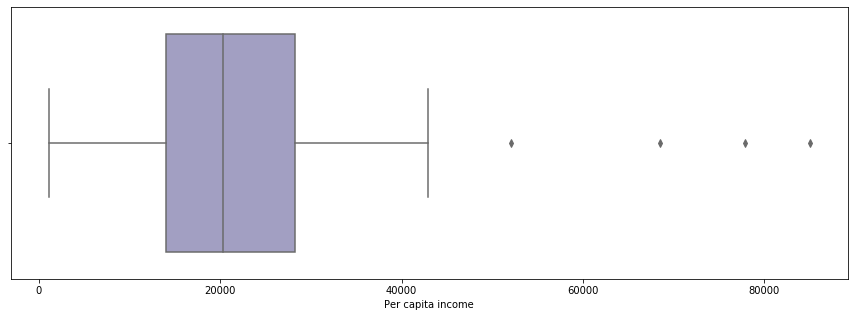

In [173]:
ax = plt.figure(figsize=(15,5))
ax = sns.boxplot(x=df['Per capita income'], orient='h', palette='Purples')

In [174]:
df['Per capita income'].describe()

count      227.000000
mean     21659.505358
std      11456.885092
min       1091.212121
25%      14035.000000
50%      20341.000000
75%      28271.000000
max      84985.000000
Name: Per capita income, dtype: float64

In [175]:
firstq = df['Per capita income'].describe()['25%']
med = df['Per capita income'].describe()['50%']
thirdq = df['Per capita income'].describe()['75%']
boxmax = 47285.0  # boxplot's max, taken from the sorted per capita values
high = df['Per capita income'].describe()['max']
print(firstq, med, thirdq, boxmax, high)

14035.0 20341.0 28271.0 47285.0 84985.0


In [176]:
for i, row in df.iterrows():
    cluster = 0
    
    if row['Per capita income'] < firstq:
        cluster = 1
    elif row['Per capita income'] < med:
        cluster = 2
    elif row['Per capita income'] < thirdq:
        cluster = 3
    elif row['Per capita income'] < boxmax:
        cluster = 4
    else:
        cluster = 5
    
    df.at[i, 'PerC_Cluster'] = cluster
df = df.astype({'PerC_Cluster':'int32'})
df

,# Killed,# Injured,Per capita income,# Incidences,Address,kills/incidence,location,latitude,longitude,PerC_Cluster
0,3,1,21185.000000,1,"Abbeville, South Carolina",3.000000,"(Abbeville County, South Carolina, United Stat...",34.226495,-82.436404,3
1,5,0,23380.000000,1,"Abington, Massachusetts",5.000000,"(Abington, Plymouth County, Massachusetts, Uni...",42.104823,-70.945322,3
2,1,7,15887.000000,2,"Akron, Ohio",0.500000,"(Akron, Summit County, Ohio, United States of ...",41.083064,-81.518485,2
3,0,4,18887.000000,1,"Albany, Georgia",0.000000,"(Albany, Dougherty County, Georgia, United Sta...",31.578206,-84.155681,2
4,5,9,8958.666667,3,"Albuquerque, New Mexico",1.666667,"(Albuquerque, Bernalillo County, New Mexico, U...",35.084103,-106.650985,1
...,...,...,...,...,...,...,...,...,...,...
222,2,2,16282.000000,1,"Wilmington, California",2.000000,"(Wilmington, Los Angeles, Los Angeles County, ...",33.780018,-118.262571,2
223,0,10,13531.000000,2,"Wilmington, Delaware",0.000000,"(Wilmington, New Castle County, Delaware, Unit...",39.745947,-75.546589,1
224,2,11,13334.000000,2,"Winston Salem , North Carolina",1.000000,"(Winston-Salem, Forsyth County, North Carolina...",36.099813,-80.244052,1
225,0,5,26103.000000,1,"Yucaipa, California",0.000000,"(Yucaipa, San Bernardino County, California, 9...",34.033625,-117.043087,3


Now I'm going to map these clusters first by the number of instances

In [180]:
PerCapitaCluster_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

colors=['red', 'blue', 'purple', 'yellow', 'green']
for address, lat, lng, num, cluster in zip(df['Address'], df['latitude'], df['longitude'], df['# Incidences'], df['PerC_Cluster']):
    label = folium.Popup(address, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=num*2,
        popup=label,
        color=colors[cluster-1],
        fill=True,
        fill_color=colors[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(PerCapitaCluster_map)

PerCapitaCluster_map

Now let's look at the distribution of those clusters instead in terms of killings per incidence

In [182]:
PerCapitaCluster_map2 = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

colors=['red', 'blue', 'purple', 'yellow', 'green']
for address, lat, lng, num, cluster in zip(df['Address'], df['latitude'], df['longitude'], df['kills/incidence'], df['PerC_Cluster']):
    label = folium.Popup(address, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=num*2,
        popup=label,
        color=colors[cluster-1],
        fill=True,
        fill_color=colors[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(PerCapitaCluster_map2)

PerCapitaCluster_map2

This third map shows the number killed for each per capita income cluster

In [184]:
PerCapitaCluster_map3 = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

colors=['red', 'blue', 'purple', 'yellow', 'green']
for address, lat, lng, num, cluster in zip(df['Address'], df['latitude'], df['longitude'], df['# Killed'], df['PerC_Cluster']):
    label = folium.Popup(address, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=num*2,
        popup=label,
        color=colors[cluster-1],
        fill=True,
        fill_color=colors[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(PerCapitaCluster_map3)

PerCapitaCluster_map3

From these maps, we can see that there is a pattern where the mere magnitude of incidences and killings is significantly higher in cities with lower per capita income (maps 1 and 3).  However, once we look at the killings per incidence, the distribution evens out slightly across each cluster (map 2).  

Therefore, it is clear that the number of incidences is higher in lower income cities, but that does not necessarily say anything about the violence of those instances.

In [190]:
{
    "tags": [
        "hide_input",
        "hide_output"
    ]
}
CLIENT_ID = 'Z0CJRXADEV3O4UPSYV3ODCBGZOJFG0B0KKT4KNBVPUUTX5NT'
CLIENT_SECRET = 'WX1XPYKYOOBLPMUA54NY3RAJZJOVQ1P3H0WC1O3OC3WVP2SU'
VERSION = '20180605'